In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
register_matplotlib_converters()
from time import time
import warnings
warnings.filterwarnings('ignore')

# Catfish Sales Data

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#read data
catfish_sales = pd.read_csv('/content/drive/MyDrive/Advanced_Machine_Learning/Time_Series_Analysis/TimeSeriesUpload/catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [5]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [6]:
start_date = datetime(2000,1,1)
end_date = datetime(2004,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

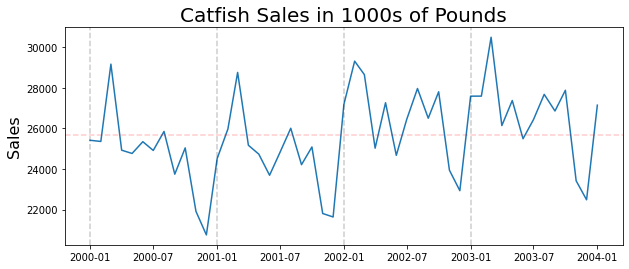

In [7]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(lim_catfish_sales.mean(), color='r', alpha=0.2, linestyle='--')

In [8]:
first_diff = lim_catfish_sales.diff()[1:]

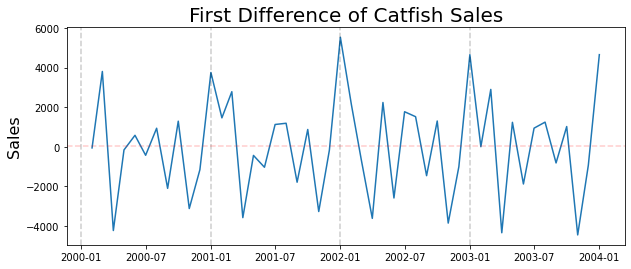

In [9]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(first_diff.mean(), color='r', alpha=0.2, linestyle='--')

# ACF

<BarContainer object of 20 artists>

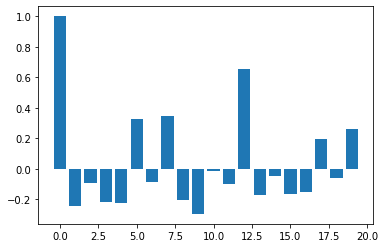

In [12]:
acf_vals = acf(first_diff)
plt.bar(range(20), acf_vals[:20])

## Based on ACF, we should start with a MA(1) process

# PACF

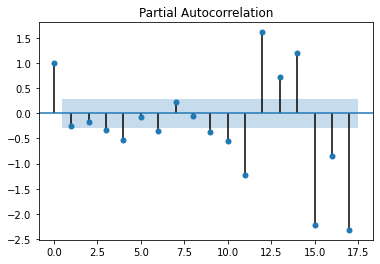

In [17]:
pacf_vals = plot_pacf(first_diff)

## Based on PACF, we should start with a AR(4) process

# Get training and testing sets

In [18]:
train_end = datetime(2003,7,1)
test_end = datetime(2004,1,1)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]

# Fit the ARMA Model

In [19]:
# define model
model = ARMA(train_data, order=(4,1))

In [20]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.3610718250274658


In [21]:
#summary of the model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Total   No. Observations:                   42
Model:                     ARMA(4, 1)   Log Likelihood                -376.584
Method:                       css-mle   S.D. of innovations           1850.781
Date:                Fri, 09 Dec 2022   AIC                            767.167
Time:                        07:54:20   BIC                            779.331
Sample:                    02-01-2000   HQIC                           771.626
                         - 07-01-2003                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.2620    129.751      0.287      0.774    -217.045     291.569
ar.L1.Total    -0.8666      0.185     -4.692      0.000      -1.229      -0.505
ar.L2.Total    -0.4236      0.166     -2.547    

## So the ARMA(4,1) model is:

## $\hat{y_t} = -0.87y_{t-1} - 0.42y_{t-2} - 0.56y_{t-3} - 0.61y_{t-4} + 0.52\varepsilon_{t-1}$

In [22]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [23]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

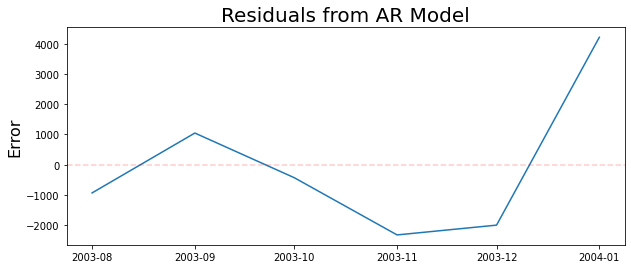

In [24]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

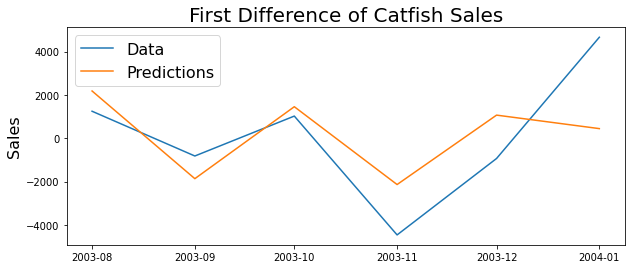

In [25]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [26]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2210.274842537195
